In [65]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib
import seaborn as sns
import graphviz 
import numpy
from sklearn.neighbors import NearestCentroid
from scipy import sparse
import warnings
from numpy import linalg

pd.set_option('display.max_columns', None)

In [138]:
def sum_of_squares(centroids, data_encoded_clustered,clustering_cols):
    
    total_dist = 0
    for cluster in range(centroids.shape[0]):

        centroid_dist = 0
        for i in list(data_encoded_clustered[data_encoded_clustered['Cluster'] == cluster].index):

            centroid_dist = centroid_dist + np.square(list(data_encoded_clustered[clustering_cols].loc[i]) - centroids[cluster]).sum()

        total_dist = total_dist + centroid_dist
    return total_dist

In [3]:
def centroid_calc(data_encoded_clustered, cont_cols):
     
    clf = NearestCentroid()
    clf.fit(data_encoded_clustered[cont_cols], data_encoded_clustered['Cluster'])

    return clf.centroids_

In [4]:
def one_hot(df, columns):
    
    for col in columns:
        
        one_hot = pd.get_dummies(df[col], prefix = col)
        df = pd.concat([df, one_hot], axis = 1)
        df = df.drop([col],  axis = 1)
        
    return df

#### Read data and remove irrelevant columns

In [5]:
guns = pd.read_csv('gunKillingsInUSA.csv')
guns = guns.drop(columns= ['Date Killed', 'City', 'Victim Name', 'Source', ])

In [6]:
# guns_prof = ProfileReport(guns)
# guns_prof.to_file(output_file='guns_profile.html')

In [7]:
# for i in range(len(guns)):
#     guns.loc[i,'missing'] = guns.loc[i].isna().sum()

# guns['missing'].hist(bins=17,figsize=(8,5))
# plt.xlabel("Number of Missing Values Per Instance")
# plt.ylabel("Count")

#### Fill missing gun law values with unavailable

In [8]:
guns[['Long Gun - State Permit to Purchase',
       'Long Gun - Firearm registration', 'Long Gun - Assault weapon law',
       'Long Gun - Owner license required', 'Long Gun - Carry permits issued',
       'Long Gun - Open Carry',
       'Long Gun - State Preemption of local restrictions',
       'Long Gun - NFA weapons restricted',
       'Long Gun - Peaceable Journey laws',
       'Handgun - State Permit to Purchase', 'Handgun - Firearm registration',
       'Handgun - Assault weapon law', 'Handgun - Owner license required',
       'Handgun - Carry permits issued', 'Handgun - Open Carry',
       'Handgun - State Preemption of local restrictions',
       'Handgun - NFA weapons restricted', 'Handgun - Peaceable Journey laws']] = guns[['Long Gun - State Permit to Purchase',
       'Long Gun - Firearm registration', 'Long Gun - Assault weapon law',
       'Long Gun - Owner license required', 'Long Gun - Carry permits issued',
       'Long Gun - Open Carry',
       'Long Gun - State Preemption of local restrictions',
       'Long Gun - NFA weapons restricted',
       'Long Gun - Peaceable Journey laws',
       'Handgun - State Permit to Purchase', 'Handgun - Firearm registration',
       'Handgun - Assault weapon law', 'Handgun - Owner license required',
       'Handgun - Carry permits issued', 'Handgun - Open Carry',
       'Handgun - State Preemption of local restrictions',
       'Handgun - NFA weapons restricted', 'Handgun - Peaceable Journey laws']].fillna('unavailable')

In [9]:
guns['Victim Age Group'] = guns['Victim Age Group'].fillna(guns['Victim Age Group'].mode()[0])
guns['Victim Gender'] = guns['Victim Gender'].fillna(guns['Victim Gender'].mode()[0])

In [10]:
adult_mean = guns[guns['Victim Age Group'] == 'adult']['Victim Age'].mean()
teen_mean = guns[guns['Victim Age Group'] == 'teen']['Victim Age'].mean()
child_mean = guns[guns['Victim Age Group'] == 'child']['Victim Age'].mean()

for i in range(len(guns)):
    
    if np.isnan(guns.loc[i,'Victim Age']): 
        
        if guns.loc[i,'Victim Age Group'] == 'adult': guns.loc[i,'Victim Age'] = adult_mean
            
        elif guns.loc[i,'Victim Age Group'] == 'teen': guns.loc[i,'Victim Age'] = teen_mean
            
        elif guns.loc[i,'Victim Age Group'] == 'child': guns.loc[i,'Victim Age'] = child_mean
            
    else: continue

#### Encoding dictionary

In [11]:
encoding_dict = {"Victim Age Group": {"child": 0, "teen": 0.5, "adult": 1},
                 "Victim Gender": {"Male": 0, "Female": 1},
                 "Long Gun - State Permit to Purchase": {"No": 0, "Yes": 0.5, "unavailable": 1},
                 "Long Gun - Firearm registration": {"No": 0, "Yes": 0.5, "unavailable": 1},
                 "Long Gun - Assault weapon law": {"No": 0, "Yes": 0.5, "unavailable": 1},
                 "Long Gun - Owner license required": {"No": 0, "Yes": 0.5, "unavailable": 1},
                 "Long Gun - Carry permits issued": {"No": 0, "Yes": 0.5, "unavailable": 1},
                 "Long Gun - Open Carry": {"No": 0, "Yes": 0.5, "unavailable": 1},
                 "Long Gun - Peaceable Journey laws": {"No": 0, "Yes": 0.5, "unavailable": 1},
                 "Handgun - State Permit to Purchase": {"No": 0, "Yes": 0.5, "unavailable": 1},
                 "Handgun - Assault weapon law": {"No": 0, "Yes": 0.5, "unavailable": 1},
                 "Handgun - Owner license required": {"No": 0, "Yes": 0.5, "unavailable": 1},
                 "Handgun - Open Carry": {"No": 0, "Yes": 0.5, "unavailable": 1},
                 "Handgun - Peaceable Journey laws": {"No": 0, "Yes": 0.5, "unavailable": 1},
                 "Long Gun - State Preemption of local restrictions": {"No": 0, "Yes": 0.33, "unavailable": 0.67, "Partial": 1},
                 "Long Gun - NFA weapons restricted": {"No": 0, "Yes": 0.33, "unavailable": 0.67, "Partial": 1},
                 "Handgun - State Permit to Purchase": {"No": 0, "Yes": 0.33, "unavailable": 0.67, "Partial": 1},
                 "Handgun - Firearm registration": {"No": 0, "Yes": 0.33, "unavailable": 0.67, "Partial": 1},
                 "Handgun - State Preemption of local restrictions": {"No": 0, "Yes": 0.33, "unavailable": 0.67, "Partial": 1},
                 "Handgun - NFA weapons restricted": {"No": 0, "Yes": 0.33, "unavailable": 0.67, "Partial": 1},
                 "Handgun - Carry permits issued": {"No": 0, "Yes": 0.33, "unavailable": 0.67, "Shall-Issue": 1},
                 "Long Gun - State Permit to Purchase": {"No": 0, "Yes": 0.33, "unavailable": 0.67, "Partial": 1},
                 "Date Killed.year": {2012: 0, 2013: 1}}

In [12]:
guns_encoded = guns.copy()

#### One-hot encode state

In [18]:
guns_encoded.loc[guns_encoded.loc[guns_encoded['BG Checks per 100k'] > 35000].index,'BG Checks per 100k'] = np.nan
bg_checks_mean = guns_encoded['BG Checks per 100k'].mean()
guns_encoded['BG Checks per 100k'] =guns_encoded['BG Checks per 100k'].fillna(bg_checks_mean)

In [13]:
guns_encoded = one_hot(guns_encoded, columns = ['State'])

In [14]:
# guns_encoded = guns.copy()
# guns_encoded['State'] = guns_encoded['State'].astype('category')
# guns_encoded['State_cat'] = guns_encoded['State'].cat.codes

# guns_state_cat = guns_encoded[["State","State_cat"]]
# guns_state_cat = guns_state_cat.drop_duplicates(ignore_index=True).sort_values(by="State_cat").reset_index(drop=True)

# guns_encoded = guns_encoded.drop('State', axis=1)
# guns_encoded = guns_encoded.rename(columns = {'State_cat': 'State'})
guns_encoded = guns_encoded.replace(encoding_dict)

In [15]:
# guns_prof_after = ProfileReport(guns)
# guns_prof_after.to_file(output_file='guns_profile_after.html')

#### Deal with outliers

In [16]:
numeric_cols = ['Victim Age', 'Latitude', 'Longitude', 'State Population', 'BG Checks per 100k']

In [17]:
# sns.set_theme(style="white")
# sns.pairplot(guns[numeric_cols])
# plt.savefig('images/splom.png',bbox_inches = 'tight');

In [19]:
# guns['BG Checks per 100k'].hist(bins=20,figsize=(8,5))
# plt.xlabel("BG Chekcs per 100k")
# plt.ylabel("Count")


In [20]:
# sns.set_theme(style="white")
# sns.pairplot(guns[numeric_cols])
# plt.savefig('images/splom_after.png',bbox_inches = 'tight');

#### Scale features

In [21]:
# for i in range(len(guns)):
#     guns.loc[i,'missing'] = guns.loc[i].isna().sum()

# # guns['missing'].hist(bins=17,figsize=(8,5))
# # plt.xlabel("Number of Missing Values Per Instance")
# # plt.ylabel("Count")

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

guns_scaled = scaler.fit_transform(guns_encoded)

guns_scaled_df = pd.DataFrame(columns = guns_encoded.columns, data = guns_scaled)

In [23]:
guns_scaled_df.to_csv('guns_scaled.csv', index=False)

In [24]:
guns_columns = guns_encoded.columns.to_list()

## Minisom

In [25]:
from minisom import MiniSom    
som = MiniSom(20, 20, 80, sigma=0.3, learning_rate=0.5) # initialization of 6x6 SOM
som.train(guns_scaled, 10000) # trains the SOM with 100 iterations

In [26]:
som.winner(guns_scaled[300])

(11, 19)

In [28]:
# Initialization and training
n_neurons = 9
m_neurons = 9
som = MiniSom(n_neurons, m_neurons, guns_scaled.shape[1], sigma=1, learning_rate=.1, 
              neighborhood_function='gaussian', random_seed=99)

# som.pca_weights_init(guns_scaled)
som.train(guns_scaled, 1000000, verbose=True)  # random training

In [272]:
dims = [2,3,4,5,6,7,8,9,10,12,15,20,25,30,35,40,45,50]

In [273]:
qe_df = pd.DataFrame(columns=['dims', 'qe'])
i = 0
for n in dims:
    n_neurons = n
    m_neurons = n
    
    som = MiniSom(n_neurons, m_neurons, guns_scaled.shape[1], sigma=1, learning_rate=.1, 
              neighborhood_function='gaussian', random_seed=99)
    
    som.train(guns_scaled, 50000, verbose=True)
    
    qe_df.loc[i,'dims'] = n
    qe_df.loc[i,'qe'] = som.quantization_error(guns_scaled)
    
    i = i + 1
    

 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 1.8621626322974638
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 1.4935021597454405
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 1.2713047140839306
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 1.153841421942711
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 1.040550285957761
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.9596917245803477
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.9015038250567227
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.8317242997674783
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.7696769639180053
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.6894547004819063
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.5964678101497035
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.4891130494352962
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 q

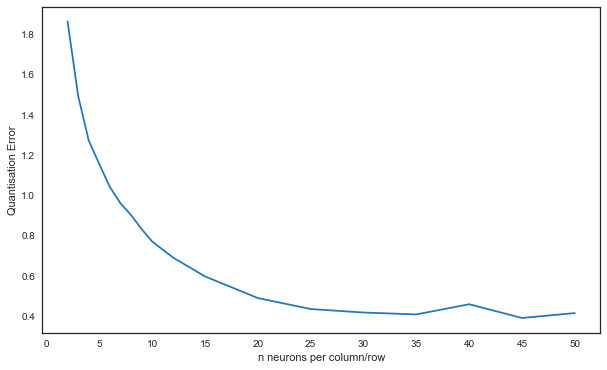

In [275]:
plt.style.use('seaborn-white')
qe_df.plot.line(x='dims',y='qe',xticks=range(0,55,5),figsize=(10,6),ylabel="Quantisation Error",xlabel='n neurons per column/row',legend=False)
plt.savefig('images/02 Quantisation Error som dims.png',bbox_inches = 'tight');

In [30]:
# som = MiniSom(35, 35, guns_scaled.shape[1], sigma=1, learning_rate=.1, 
#           neighborhood_function='gaussian', random_seed=99, topology='hexagonal')

# som.train(guns_scaled, 100000, verbose=True)

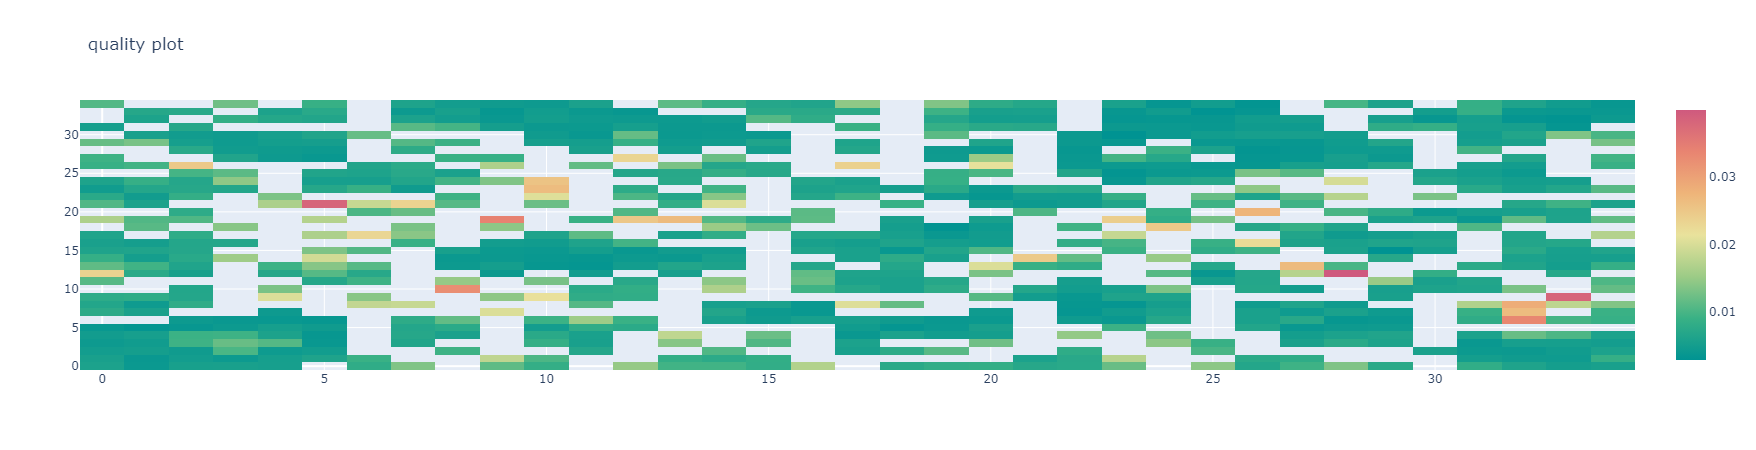

In [321]:
import plotly.graph_objects as go

win_map = som.win_map(guns_scaled)
size=som.distance_map().shape[0]
qualities=np.empty((size,size))
qualities[:]=np.NaN
for position, values in win_map.items():
    qualities[position[0], position[1]] = np.mean(abs(values-som.get_weights()[position[0], position[1]]))

layout = go.Layout(title='quality plot',width=10)
fig = go.Figure(layout=layout)
fig.add_trace(go.Heatmap(z=qualities, colorscale='temps'))
fig.show()

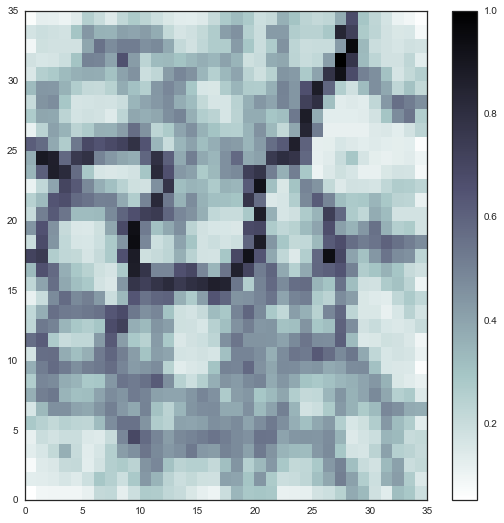

In [322]:
plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
# markers = ['o', 's', 'D']
# colors = ['C0', 'C1', 'C2']
for cnt, xx in enumerate(guns_scaled):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markerfacecolor='None', markersize=12, markeredgewidth=2)

plt.show()

In [351]:
sigma_list = [0.5,1,1.5,2,3]
learning_rate_list = [0.1,0.5,1,1.5,2]
neighbour_list = ['gaussian', 'mexican_hat']
act_dist_list = ['euclidean', 'manhattan']

In [553]:
grid_search = pd.DataFrame(columns=['Sigma', 'Learning Rate', 'Neighbourhood Function', 'Activation Distance', 'Quantisation Error'])
i = 0
for act_dist in act_dist_list:
    
    for neighbour in neighbour_list:
        
        for learning_rate in learning_rate_list:
            
            for sigma in sigma_list:
                
                    som = MiniSom(35, 35, guns_scaled.shape[1], sigma=sigma, learning_rate=learning_rate, neighborhood_function=neighbour, activation_distance = act_dist, random_seed=99)
    
                    som.train(guns_scaled, 10000, verbose=False)
    
                    grid_search.loc[i,'Sigma'] = sigma
                    grid_search.loc[i,'Learning Rate'] = learning_rate
                    grid_search.loc[i,'Neighbourhood Function'] = neighbour
                    grid_search.loc[i,'Activation Distance'] = act_dist
                    grid_search.loc[i,'Quantisation Error'] = som.quantization_error(guns_scaled)
            
                    i = i + 1
                    
                    if i % 10 == 0: print('Number of tests = ', i)
                

In [354]:
grid_search.to_csv('test_1_33.csv')

In [26]:
som = MiniSom(35, 35, guns_scaled.shape[1], sigma=1, learning_rate=1.5, neighborhood_function='gaussian', activation_distance = 'euclidean', random_seed=99)

som.train(guns_scaled, 1000000, verbose=True)

 [ 1000000 / 1000000 ] 100% - 0:00:00 left 
 quantization error: 0.35097786548331694


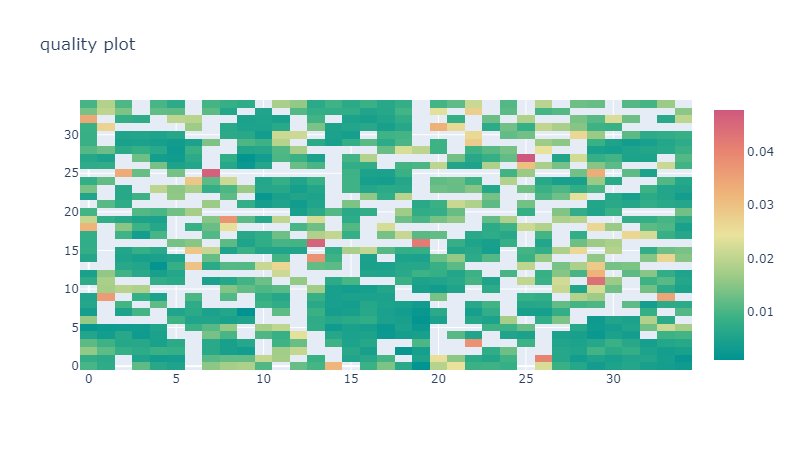

In [27]:
import plotly.graph_objects as go

win_map = som.win_map(guns_scaled)
size=som.distance_map().shape[0]
qualities=np.empty((size,size))
qualities[:]=np.NaN
for position, values in win_map.items():
    qualities[position[0], position[1]] = np.mean(abs(values-som.get_weights()[position[0], position[1]]))

layout = go.Layout(title='quality plot',width=10)
fig = go.Figure(layout=layout)
fig.add_trace(go.Heatmap(z=qualities, colorscale='temps'))
fig.show()

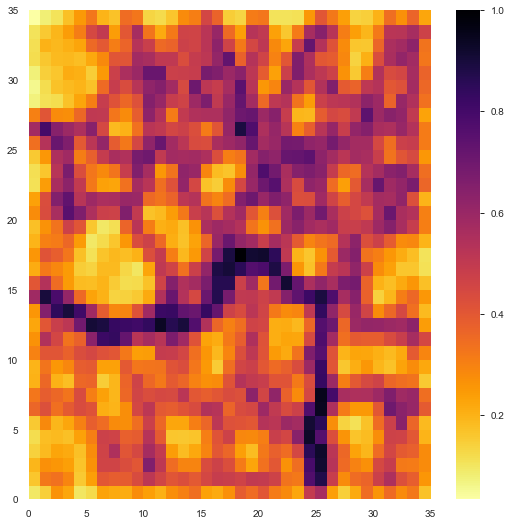

In [28]:
plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='inferno_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
# markers = ['o', 's', 'D']
# colors = ['C0', 'C1', 'C2']
for cnt, xx in enumerate(guns_scaled):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markerfacecolor='None', markersize=12, markeredgewidth=2)

plt.show()

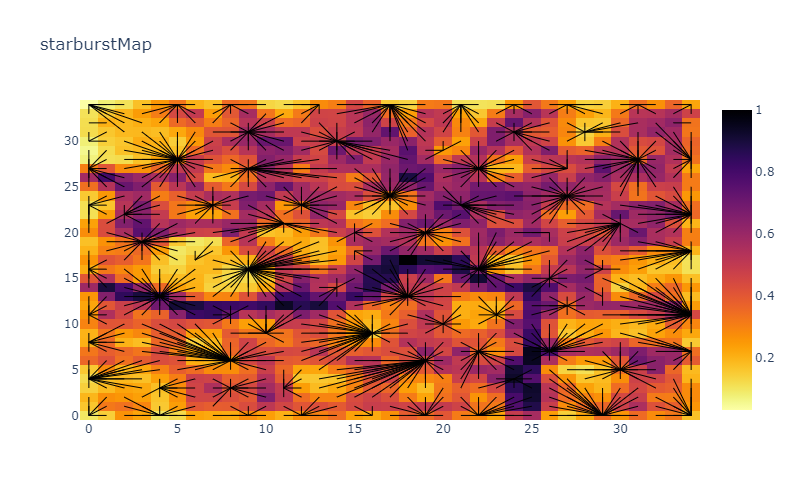

In [29]:
def findMin(x, y, umat):
    newxmin=max(0,x-1)
    newxmax=min(umat.shape[0],x+2)
    newymin=max(0,y-1)
    newymax=min(umat.shape[1],y+2)
    minx, miny = np.where(umat[newxmin:newxmax,newymin:newymax] == umat[newxmin:newxmax,newymin:newymax].min())
    return newxmin+minx[0], newymin+miny[0]

def findInternalNode(x, y, umat):
    minx, miny = findMin(x,y,umat)
    if (minx == x and miny == y):
        cx = minx
        cy = miny
    else:
        cx,cy = findInternalNode(minx,miny,umat)
    return cx, cy

import matplotlib
from matplotlib import cm
import numpy as np

def matplotlib_cmap_to_plotly(cmap, entries):
    h = 1.0/(entries-1)
    colorscale = []

    for k in range(entries):
        C = (np.array(cmap(k*h)[:3])*255)
        colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return colorscale

def plotStarburstMap(som):
    boner_rgb = []
    norm = matplotlib.colors.Normalize(vmin=0, vmax=255)
    bone_r_cmap = matplotlib.cm.get_cmap('bone_r')
    
    inferno_rgb = []
    inferno_r_cmap = matplotlib.cm.get_cmap('inferno_r')

    bone_r = matplotlib_cmap_to_plotly(bone_r_cmap, 255)
    inferno_r = matplotlib_cmap_to_plotly(inferno_r_cmap, 255)

    layout = go.Layout(title='starburstMap')
    fig = go.Figure(layout=layout)
    fig.add_trace(go.Heatmap(z=som.distance_map().T, colorscale=inferno_r))
    shapes=[]

    for row in np.arange(som.distance_map().shape[0]):
        for col in np.arange(som.distance_map().shape[1]):
            cx,cy = findInternalNode(row, col, som.distance_map().T)
            shape=go.layout.Shape(
                    type="line",
                    x0=row,
                    y0=col,
                    x1=cx,
                    y1=cy,
                    line=dict(
                        color="Black",
                        width=1
                    )
                )
            shapes=np.append(shapes, shape)

    fig.update_layout(shapes=shapes.tolist(), 
        width=500,
        height=500) 
    fig.show()
    
plotStarburstMap(som)

In [30]:
codebook_df = pd.DataFrame(columns = ['Instance', 'Winning Neuron', 'Neuron Weight'])
idx = 0
cbv = som.get_weights()

for idx in range(len(guns_scaled)):
    
    codebook_df.loc[idx,'Instance'] = idx
    codebook_df.loc[idx,'Winning Neuron'] = som.winner(guns_scaled[idx])
    codebook_df.loc[idx,'Neuron Weight'] = cbv[som.winner(guns_scaled[idx])[0]][som.winner(guns_scaled[idx])[1]]
    
    idx += 1

In [31]:
neuron_map_df = pd.DataFrame(columns=['Neuron', 'Instances', 'Neuron Weight'])
i = 0
for neuron in codebook_df['Winning Neuron'].unique():
    
    neuron_map_df.loc[i,'Neuron'] = neuron
    neuron_map_df.loc[i,'Instances'] = codebook_df[codebook_df['Winning Neuron'] == neuron]['Instance'].to_list()
    neuron_map_df.loc[i,'Neuron Weight'] = cbv[neuron[0]][neuron[1]]
    
    i += 1        

In [32]:
neuron_data = neuron_map_df[['Neuron', 'Neuron Weight']]

In [33]:
cols=[]
for i in range(80):
    cols.append('w'+ str(i))

In [34]:
neuron_data_clustering = pd.DataFrame(neuron_data['Neuron Weight'].to_list(), columns=cols)

In [238]:
connectivity = np.zeros((len(neuron_data),len(neuron_data)))

for idx in range(len(neuron_data)):
    accepted_neurons = []
    
    connectivity[idx][idx] = 1
    
    neuron = neuron_data.loc[idx,'Neuron']
    
    if neuron[0]-1 >= 0: accepted_neurons.append((neuron[0]-1,neuron[1]))
        
    if neuron[0]+1 <= neuron_data.index.max(): accepted_neurons.append((neuron[0]+1,neuron[1]))
        
    if neuron[1]-1 >= 0: accepted_neurons.append((neuron[0],neuron[1]-1))
        
    if neuron[1]+1 <= neuron_data.index.max(): accepted_neurons.append((neuron[0],neuron[1]+1))
        
    for accepted_neuron in accepted_neurons:

        if neuron_data[neuron_data['Neuron'] == accepted_neuron].count()[0] == 0: pass

        else:
            connection = neuron_data[neuron_data['Neuron'] == accepted_neuron].index[0]

            connectivity[idx][connection] = 1
            
connectivity_matrix = np.matrix(connectivity)
connectivity_sparse = sparse.csr_matrix(connectivity_matrix)

In [239]:
def avg_eucl_dist_calc(centroids, data_encoded_clustered,clustering_cols):
    
#     total_dist = 0
    total_eucl_dist = 0
    avg_eucl = 0
    avg_eucl_total = 0
    
    for cluster in range(centroids.shape[0]):

        centroid_dist = 0
        for i in list(data_encoded_clustered[data_encoded_clustered['Cluster'] == cluster].index):

#             centroid_dist = centroid_dist + np.square(list(data_encoded_clustered[clustering_cols].loc[i]) - centroids[cluster]).sum()
            centroid_eucl = numpy.linalg.norm(cluster - np.array(data_encoded_clustered[cols].loc[i]))
#             print(centroid_eucl)

            total_eucl_dist = total_eucl_dist + centroid_eucl
            
        avg_eucl = total_eucl_dist / data_encoded_clustered[data_encoded_clustered['Cluster'] == cluster].shape[0]
#         print(avg_eucl)
#         print('-----')
        avg_eucl_total = avg_eucl_total + avg_eucl

    return avg_eucl_total / centroids.shape[0]

In [398]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

elbow_df = pd.DataFrame(columns=['n_clusters', 'sum_square_total', 'silhouette_avg'])
i = 0
        
for n_clusters in range(2,15):
    
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="single",connectivity=connectivity_matrix)
    
    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)

        model = model.fit(neuron_data_clustering)
    
    data_encoded_clustered = pd.concat([neuron_data_clustering,pd.Series(model.labels_)], axis=1)
    data_encoded_clustered = data_encoded_clustered.rename(columns={0:'Cluster'})
    
    centroids = centroid_calc(data_encoded_clustered, cols)

#     elbow_df.loc[i,'quantisation_err'] = avg_eucl_dist_calc(centroids, data_encoded_clustered, cols)
    elbow_df.loc[i,'sum_square_total'] = sum_of_squares(centroids, data_encoded_clustered,cols)
    elbow_df.loc[i,'n_clusters'] = n_clusters
    elbow_df.loc[i,'silhouette_avg'] = silhouette_score(data_encoded_clustered, data_encoded_clustered['Cluster'])
    
    i = i +1
    
#     del data_encoded_clustered

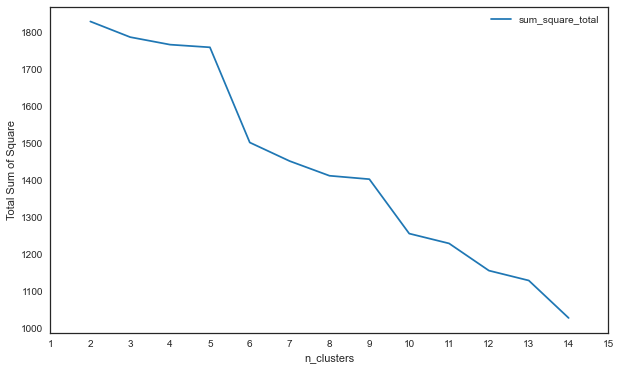

In [400]:
plt.style.use('seaborn-white')
elbow_df.plot.line(x='n_clusters',y='sum_square_total',xticks=range(1,16),figsize=(10,6),ylabel="Total Sum of Square")
plt.savefig('images/05 Sum Square Elbow.png',bbox_inches = 'tight');

In [401]:
final_model = AgglomerativeClustering(n_clusters=6, affinity="euclidean", linkage="single", connectivity=connectivity)
final_model = final_model.fit(neuron_data_clustering)

data_encoded_clustered = pd.concat([neuron_data_clustering,pd.Series(final_model.labels_)], axis=1)
data_encoded_clustered = data_encoded_clustered.rename(columns={0:'Cluster'})
# data_encoded_clustered = pd.concat([data_encoded_clustered,target], axis=1)

centroids = centroid_calc(data_encoded_clustered, cols)

C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:503: UserWarning:

the number of connected components of the connectivity matrix is 38 > 1. Completing it to avoid stopping the tree early.



In [402]:
clusters = pd.concat([data_encoded_clustered,neuron_map_df],axis=1)[['Cluster','Instances']]

In [403]:
clusters_for_plot = pd.concat([data_encoded_clustered,neuron_map_df],axis=1)[['Cluster','Neuron']]

In [404]:
for i in range(len(clusters_for_plot)):
    
    clusters_for_plot.loc[i,'x'] = clusters_for_plot.loc[i,'Neuron'][0]
    clusters_for_plot.loc[i,'y'] = clusters_for_plot.loc[i,'Neuron'][1]
    

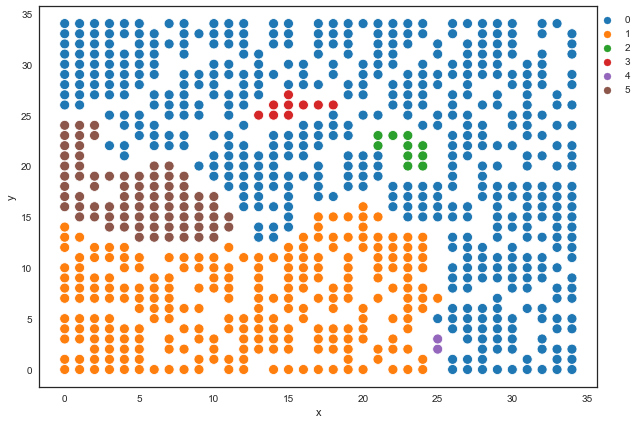

In [405]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=clusters_for_plot, x="x", y="y", hue="Cluster", palette='tab10', s=100)
plt.legend(loc=1,bbox_to_anchor=(1.075, 1),fancybox =1)
plt.savefig('images/06 SOM after clustering.png',bbox_inches = 'tight');

In [406]:
clusters_final = clusters.groupby('Cluster', as_index=False).agg({'Instances': 'sum'})

In [505]:
for cluster in clusters_final.index:
    
    for i in guns_encoded.index:
    
        if i in clusters_final.loc[cluster,'Instances']: guns_encoded.loc[i,'Cluster'] = cluster
    

In [506]:
for cluster in clusters_final.index:
    
    for i in guns.index:
    
        if i in clusters_final.loc[cluster,'Instances']: guns.loc[i,'Cluster'] = cluster

In [507]:
for cluster in clusters_final.index:
    
    for i in guns_scaled_df.index:
    
        if i in clusters_final.loc[cluster,'Instances']: guns_scaled_df.loc[i,'Cluster'] = cluster

In [416]:
num_cols = ['Victim Age', 'Latitude', 'Longitude', 'State Population', 'BG Checks per 100k', "Cluster"]

In [410]:
guns.loc[guns.loc[guns['BG Checks per 100k'] > 35000].index,'BG Checks per 100k'] = np.nan
bg_checks_mean = guns['BG Checks per 100k'].mean()
guns['BG Checks per 100k'] =guns['BG Checks per 100k'].fillna(bg_checks_mean)

In [539]:
guns.to_csv('guns_encoded_for_rule_extraction.csv', index=False)

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\MSI\Anaconda3\lib\site-packages\

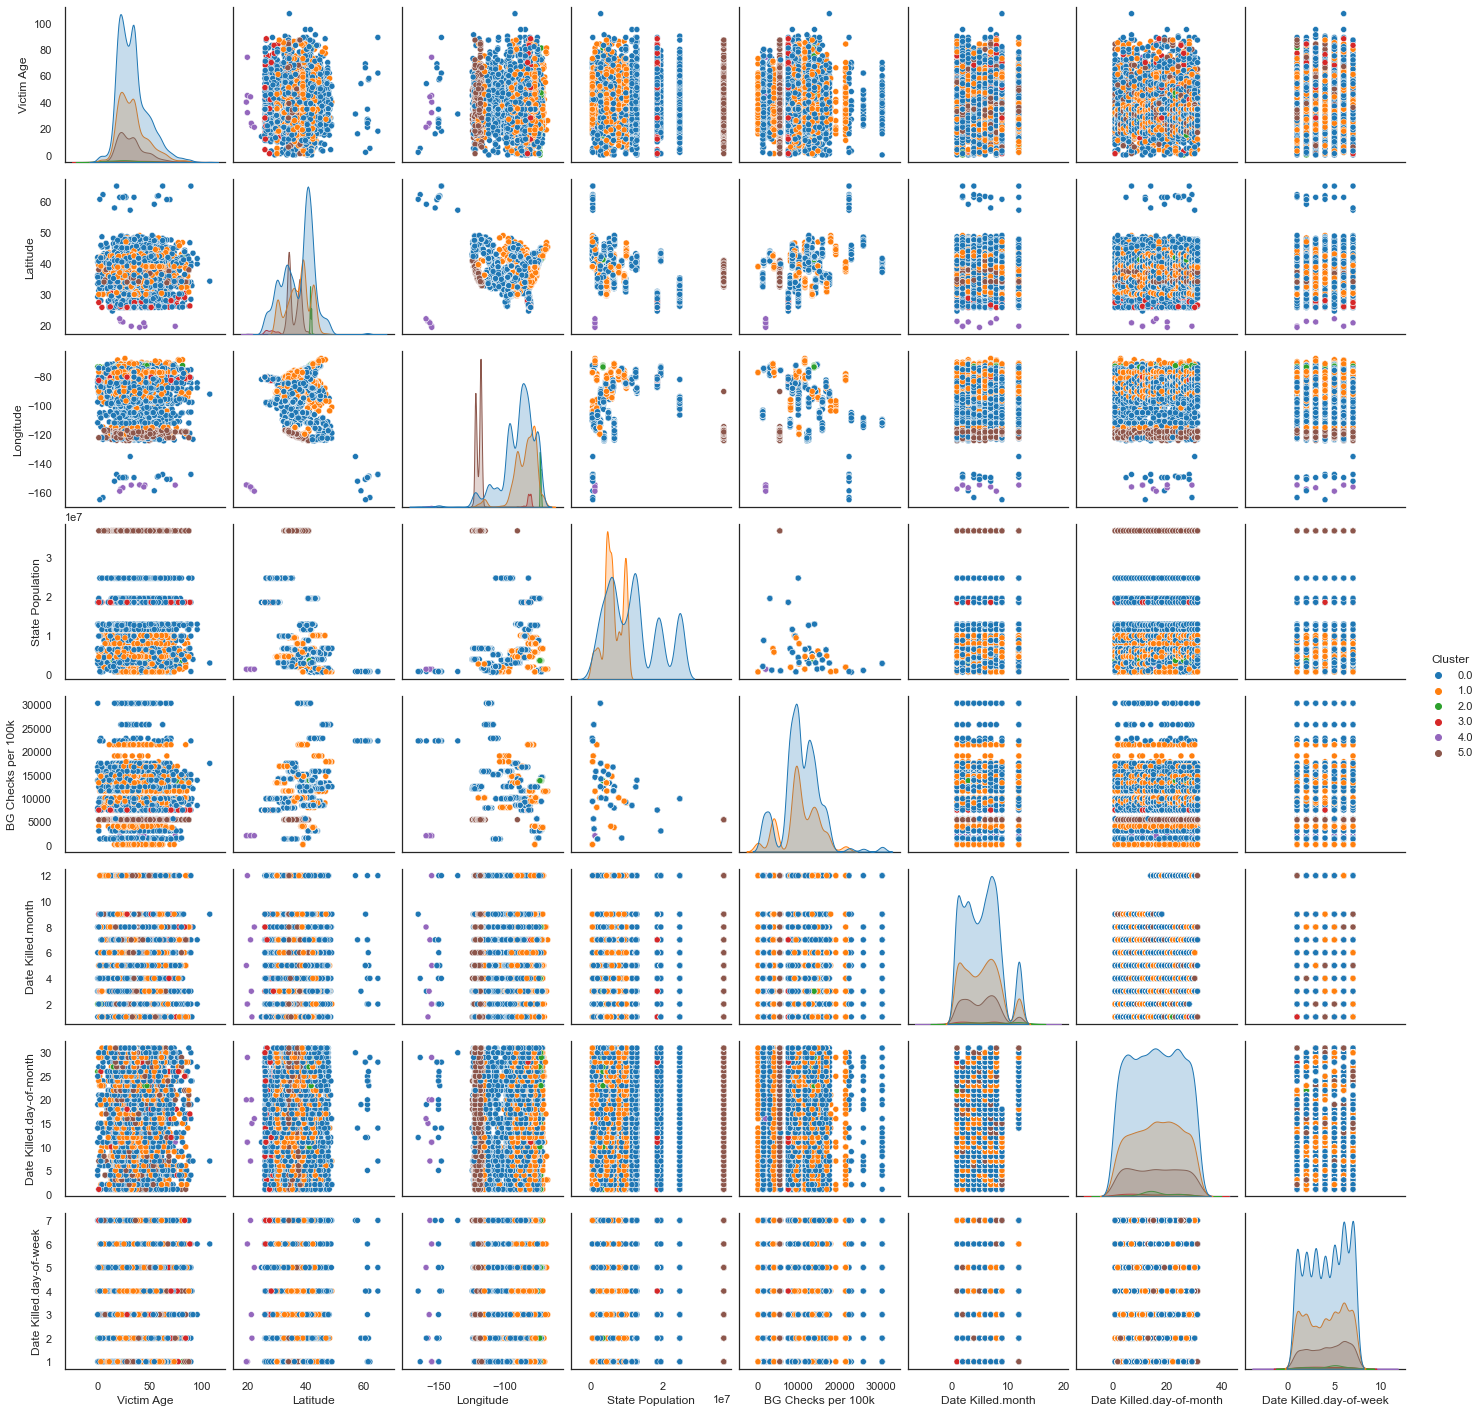

In [508]:
sns.set_theme(style="white")
sns.pairplot(guns_encoded[num_cols_2], hue='Cluster', palette='tab10')
plt.savefig('images/013 splom after clustering.png',bbox_inches = 'tight');

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\MSI\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\MSI\Anaconda3\lib\site-packages\

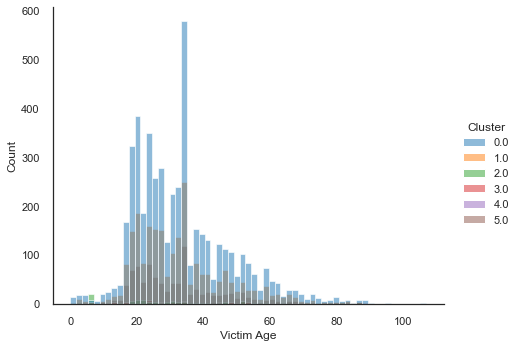

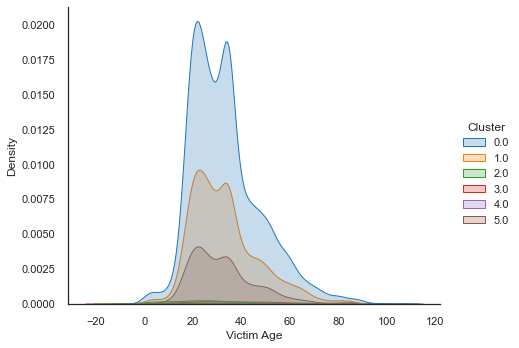

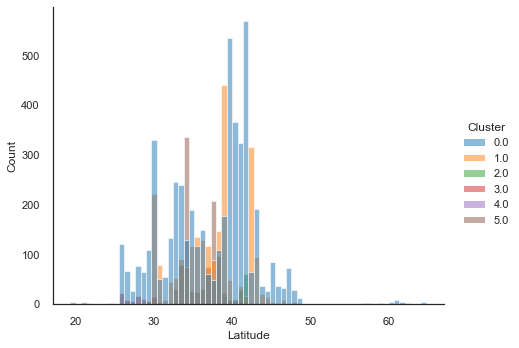

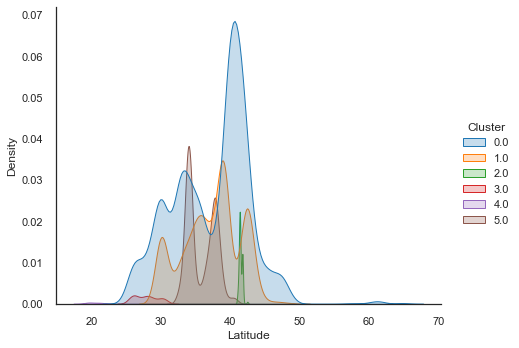

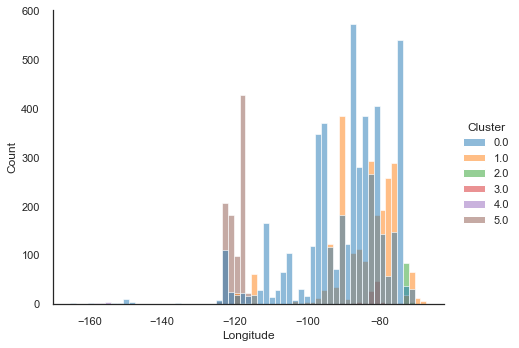

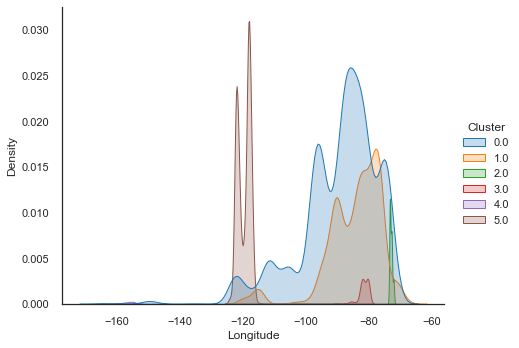

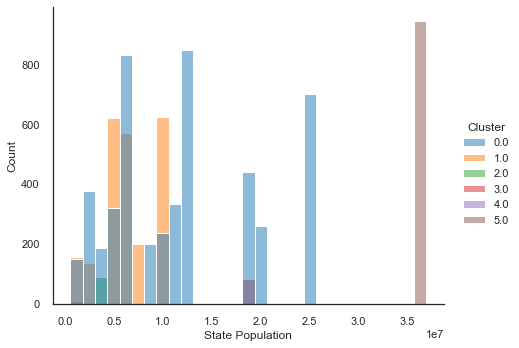

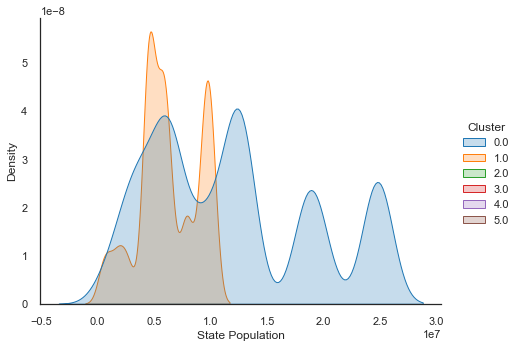

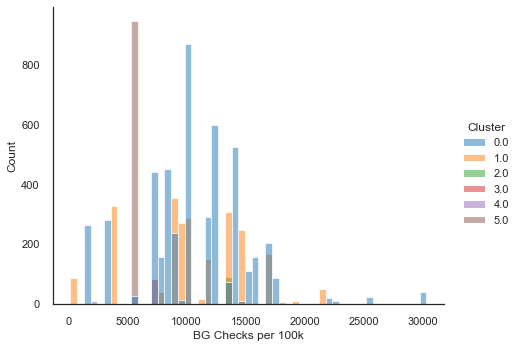

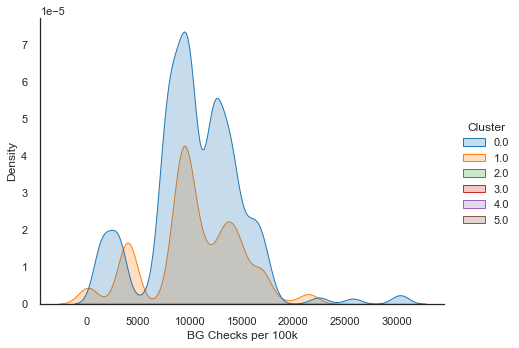

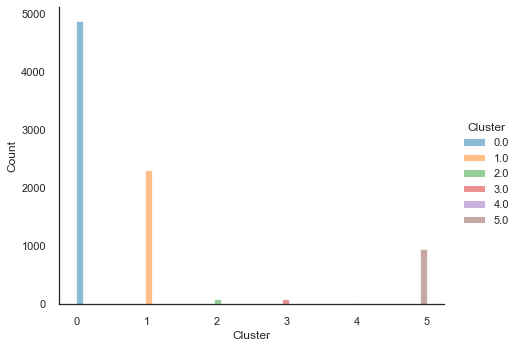

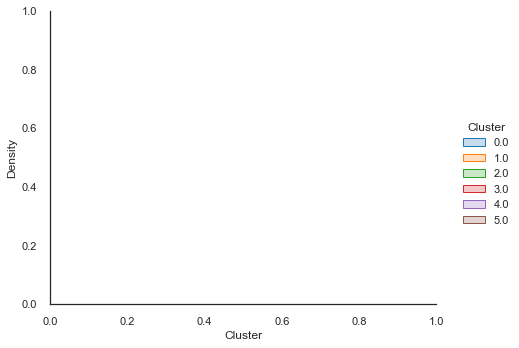

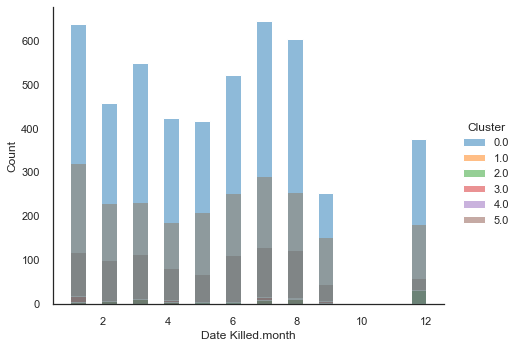

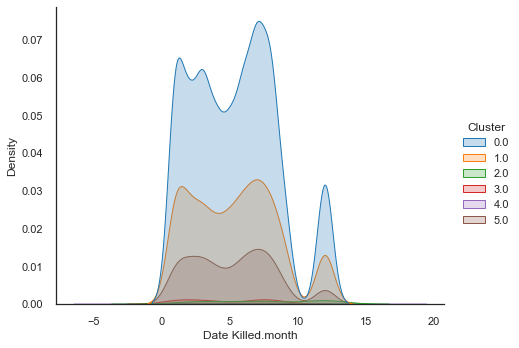

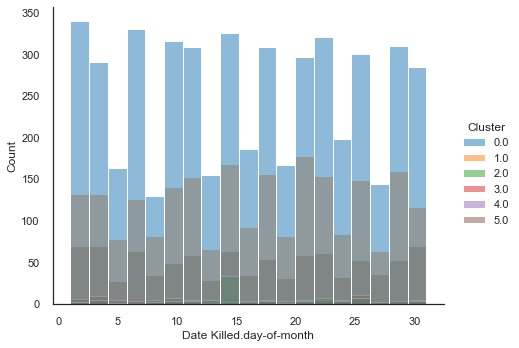

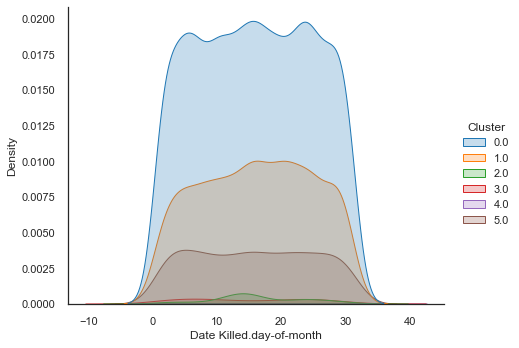

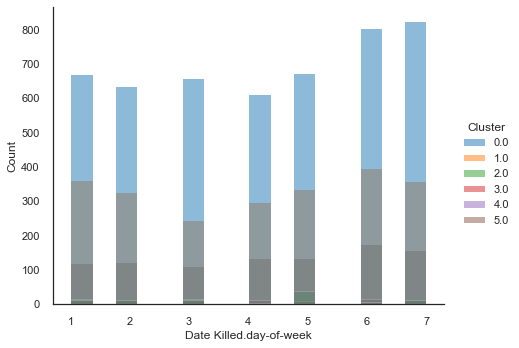

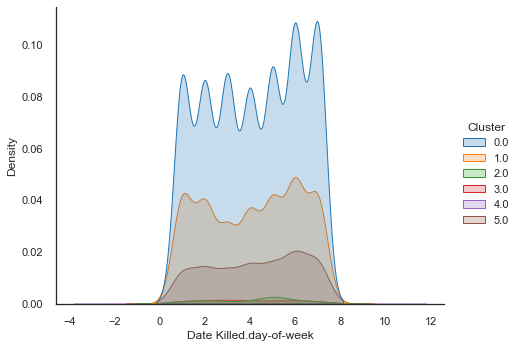

In [509]:
i = 7
for col in num_cols_2:
    
    sns.displot(guns_encoded[num_cols_2], x=col, hue="Cluster", palette='tab10',aspect=1.3)
    plt.savefig('images/0' + str(i) + ' ' + col + '_Hist.png',bbox_inches = 'tight');
    
    sns.displot(guns_encoded[num_cols_2], x=col, hue="Cluster", palette='tab10', kind="kde",fill=True,aspect=1.3)
    plt.savefig('images/0' + str(i) + ' ' + col + '_KDE.png',bbox_inches = 'tight');
    
    i += 1

In [475]:
guns.columns

Index(['State', 'Victim Age', 'Victim Age Group', 'Victim Gender', 'Latitude',
       'Longitude', 'State Population', 'BG Checks per 100k',
       'Long Gun - State Permit to Purchase',
       'Long Gun - Firearm registration', 'Long Gun - Assault weapon law',
       'Long Gun - Owner license required', 'Long Gun - Carry permits issued',
       'Long Gun - Open Carry',
       'Long Gun - State Preemption of local restrictions',
       'Long Gun - NFA weapons restricted',
       'Long Gun - Peaceable Journey laws',
       'Handgun - State Permit to Purchase', 'Handgun - Firearm registration',
       'Handgun - Assault weapon law', 'Handgun - Owner license required',
       'Handgun - Carry permits issued', 'Handgun - Open Carry',
       'Handgun - State Preemption of local restrictions',
       'Handgun - NFA weapons restricted', 'Handgun - Peaceable Journey laws',
       'Date Killed.year', 'Date Killed.month', 'Date Killed.day-of-month',
       'Date Killed.day-of-week', 'Cluster'],


In [519]:
num_cols_2 = ['Victim Age', 'Latitude', 'Longitude', 'State Population', 'BG Checks per 100k', 'Date Killed.month','Date Killed.day-of-month','Date Killed.day-of-week', "Cluster"]

In [526]:
guns_encoded[guns_encoded['Cluster']==5][num_cols_2].describe()

Victim Age    Latitude   Longitude  State Population  \
count  945.000000  945.000000  945.000000             945.0   
mean    32.299542   35.795240 -119.671546        36961664.0   
std     13.462627    1.998314    2.183016               0.0   
min      1.000000   32.353544 -124.262243        36961664.0   
25%     22.000000   34.050171 -121.793643        36961664.0   
50%     30.000000   35.201316 -118.973757        36961664.0   
75%     38.000000   37.778960 -118.187362        36961664.0   
max     87.000000   40.866517  -90.210388        36961664.0   

       BG Checks per 100k  Date Killed.month  Date Killed.day-of-month  \
count               945.0         945.000000                945.000000   
mean               5444.0           5.253968                 15.828571   
std                   0.0           3.009703                  9.091824   
min                5444.0           1.000000                  1.000000   
25%                5444.0           3.000000                  8.000000   
50%                5444.0           5.000000                 16.000000   
75%                5444.0           7.000000                 24.000000   
max                5444.0          12.000000                 31.000000   

       Date Killed.day-of-week  Cluster  
count               945.000000    945.0  
mean                  4.257143      5.0  
std                   2.014385      0.0  
min                   1.000000      5.0  
25%                   2.000000      5.0  
50%                   4.000000      5.0  
75%                   6.000000      5.0  
max                   7.000000      5.0

In [540]:
guns[guns['Cluster']==1]['State'].value_counts()

Michigan           353
Louisiana          307
North Carolina     270
Missouri           246
Maryland           244
Virginia           200
Alabama            165
South Carolina     149
Nevada              85
Washington D.C.     85
Massachusetts       82
West Virginia       51
Nebraska            39
Maine               17
South Dakota        10
North Dakota         6
Name: State, dtype: int64

In [ ]:
sns.barplot(x="day", y="tip", data=tips, ci=68)

In [438]:
columns = guns_scaled_df.columns.to_list()

ValueError: num must be 1 <= num <= 80, not 81

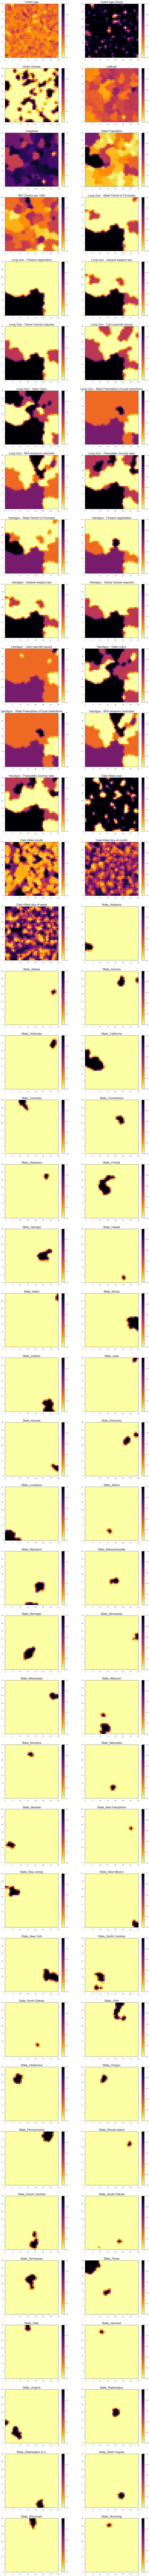

In [471]:
feature_names=columns
W = som.get_weights()
plt.figure(figsize=(20, 360))
for i, f in enumerate(feature_names):
    plt.subplot(40, 2, i+1)
    plt.title(f, fontsize=22)
    c = plt.pcolor(W[:,:,i].T, cmap='inferno_r',vmin=0,vmax=1)
    plt.xticks(np.arange(size+1, step=5), fontsize=12)
    plt.yticks(np.arange(size+1, step=5), fontsize=12)
    plt.colorbar()
    
plt.tight_layout()
plt.savefig('images/014 Component Maps.png',bbox_inches = 'tight');
plt.show()

In [190]:
i in clusters_final.loc[0,'Instances']

True

In [ ]:
guns.columns

In [567]:
from sklearn.cluster import ward_tree
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

elbow_df = pd.DataFrame(columns=['n_clusters', 'sum_square_total', 'silhouette_avg'])
i = 0
# cluster_total = 0 
for n_clusters in range(2,40):
    
    model = ward_tree(neuron_data_clustering,n_clusters=n_clusters)
#     model = model.fit(neuron_data_clustering)
    
    data_encoded_clustered = pd.concat([neuron_data_clustering,pd.Series(model.labels_)], axis=1)
    data_encoded_clustered = data_encoded_clustered.rename(columns={0:'Cluster'})
    
    centroids = centroid_calc(data_encoded_clustered, cols)

    elbow_df.loc[i,'sum_square_total'] = sum_of_squares(centroids, data_encoded_clustered,cols)
    elbow_df.loc[i,'n_clusters'] = n_clusters
    elbow_df.loc[i,'silhouette_avg'] = silhouette_score(data_encoded_clustered, data_encoded_clustered['Cluster'])
    
    i = i +1
    
#     del data_encoded_clustered

TypeError: ward_tree() missing 1 required positional argument: 'X'

In [707]:
wt = ward_tree(neuron_data_clustering,n_clusters=5, connectivity = connectivity_sparse)

C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:247: UserWarning:

the number of connected components of the connectivity matrix is 36 > 1. Completing it to avoid stopping the tree early.



In [708]:
connectivity_sparse

<829x829 sparse matrix of type '<class 'numpy.float64'>'
	with 3103 stored elements in Compressed Sparse Row format>

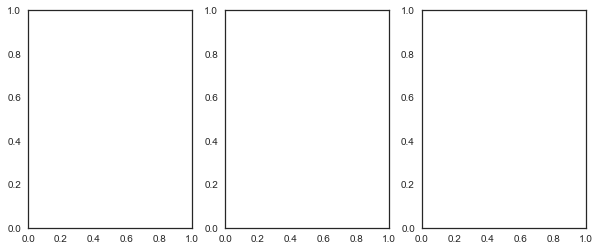

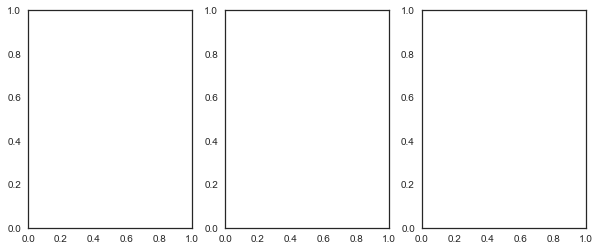

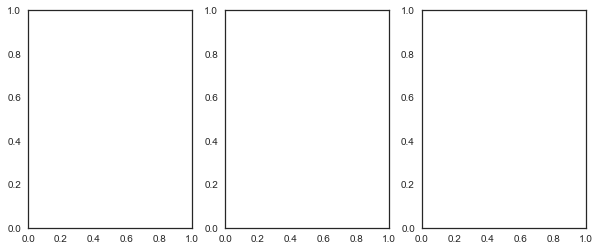

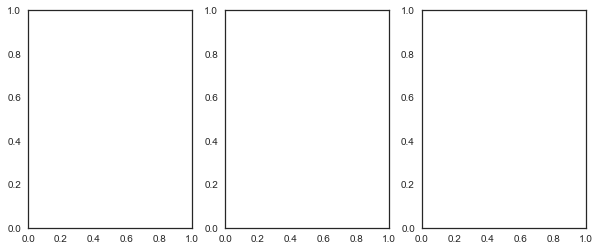

In [719]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += .7 * np.random.randn(2, n_samples)
X = X.T

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 30, include_self=False)

for connectivity in (None, knn_graph):
    i +=1
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average', 'complete', 'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
#             plt.scatter(X[:, 0], X[:, 1], c=model.labels_,
#                         cmap=plt.cm.spectral)
#             plt.title('linkage=%s (time %.2fs)' % (linkage, elapsed_time),
#                       fontdict=dict(verticalalignment='top'))
#             plt.axis('equal')
#             plt.axis('off')

#             plt.subplots_adjust(bottom=0, top=.89, wspace=0,
#                                 left=0, right=1)
#             plt.suptitle('n_cluster=%i, connectivity=%r' %
#                          (n_clusters, connectivity is not None), size=17)


# plt.show()

In [726]:
connectivity

<1500x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 45000 stored elements in Compressed Sparse Row format>

In [576]:
ward_tree(neuron_data_clustering,n_clusters=5)

(array([[ 385,  634],
        [ 759,  808],
        [ 313,  671],
        ...,
        [1651, 1653],
        [1621, 1654],
        [1645, 1655]], dtype=int64), 1, 829, None)

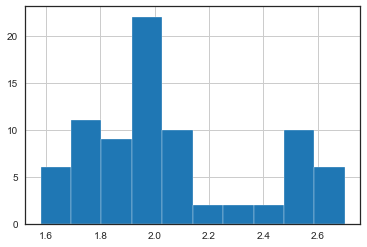

In [338]:
grid_search['Quantisation Error'].hist()

In [333]:
som = MiniSom(35, 35, guns_scaled.shape[1], sigma=1, learning_rate=.1, 
          neighborhood_function='gaussian', random_seed=99)

som.train(guns_scaled, 100, verbose=True)


 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 1.965751371889883


In [223]:
qe =som.train(guns_scaled, 100000, verbose=True)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.8518613147504355


In [250]:
som.quantization_error(guns_scaled)

0.7679857093157375

In [221]:
som.winner(guns_scaled[1])

(8, 8)

In [49]:
from somlearn import SOM
from sklearn.base import clone

In [51]:
from collections import Counter
from sklearn.datasets import make_classification
from somlearn import SOM
X, _ = make_classification(random_state=0)
som = SOM(n_columns=2, n_rows=2, random_state=1)
labels = som.fit_predict(X)
print(sorted(Counter(labels).items()))

print(som.neighbors_.tolist())

NameError: name 'wrap_train' is not defined

In [497]:
neuron_data_clustering = nueron_data.explode('Neuron Weight').reset_index(drop=True)
neuron_data_clustering['g'] = neuron_data_clustering.groupby('Neuron')['Neuron'].cumcount()
neuron_data_clustering = neuron_data_clustering.pivot(index='g', columns='Neuron', values='Neuron Weight')
neuron_data_clustering = neuron_data_clustering.reset_index(level=[0,0])

In [520]:
neuron_data_clustering_df = pd.DataFrame()
for col in neuron_data_clustering.columns:
    
    neuron_data_clustering_df[col] = neuron_data_clustering[col]
    
neuron_data_clustering_df = neuron_data_clustering_df.drop(columns=['g'])